In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pyshearlab
from pyshearlab.pySLUtilities import modulate2, dfilters
from pyshearlab.pySLFilters import MakeONFilter

In [130]:
def tv_correction(y: np.ndarray, gamma: float):
    coeffs = pywt.swt2(y, 'haar', 1, trim_approx=True)
    coeffs[1] = pywt.threshold(coeffs[1], gamma, mode='soft')
    return pywt.iswt2(coeffs, 'haar')

def reweigh_freqs(f: np.ndarray, w_freq: list):
    coeffs = pywt.swt2(f,'haar', len(w_freq)-1, trim_approx=True)
    arr, slices = pywt.coeffs_to_array(coeffs)

    arr[slices[0]] *= w_freq[0]
    for i in range(1, len(w_freq)):
        # Weigh the 3 detail components
        for slice in slices[i].values():
            arr[slice] *= w_freq[i]
    coeffs = pywt.array_to_coeffs(arr, slices,'wavedec2')

    return pywt.iswt2(coeffs, 'haar')

def get_delta_min(f: np.ndarray):
    coeffs = pywt.dwt2(f, 'db4')
    h = np.concat(coeffs[1], axis=1)
    mad = np.median(np.abs(h-np.median(h))) / 0.6745
    return 3*mad

def shearlet_threshold(f: np.ndarray, shearletSystem: dict, delta: float):
    coeffs = pyshearlab.SLsheardec2D(f, shearletSystem)
    coeffs[np.abs(coeffs/shearletSystem["RMS"][None,None,:]) < delta] = 0
    return pyshearlab.SLshearrec2D(coeffs, shearletSystem)

def swt_threshold(f: np.ndarray, delta: float, wavelet: str = 'sym4', scales: int | None = None):
    coeffs = pywt.swt2(f, wavelet, level=scales, trim_approx=True)
    arr, slices = pywt.coeffs_to_array(coeffs)
    arr[np.abs(arr) < delta] = 0
    coeffs = pywt.array_to_coeffs(arr, slices, 'wavedec2')
    return pywt.iswt2(coeffs, wavelet)

def MCA(f: np.ndarray, iterations: int, shearletSystem: dict, swt_wavelet: str = 'sym4'):
    f = reweigh_freqs(f, [0.1,0.1,2,2])
    
    delta_min = get_delta_min(f)
    coeffs_dst = pyshearlab.SLsheardec2D(f, shearletSystem)/shearletSystem["RMS"][None,None,:]
    coeffs_swt = pywt.coeffs_to_array(pywt.swt2(f, swt_wavelet, level=shearletSystem["shearLevels"].size, trim_approx=True))[0]
    delta = np.min([np.max(np.abs(coeffs_dst)), np.max(np.abs(coeffs_swt))]) # Initial threshold
    lambd = (delta/delta_min)**(1/(1-iterations)) # Threshold decay factor
    
    f0 = np.zeros_like(f)
    f1 = np.zeros_like(f)

    for _ in range(iterations):
        f_res = f - (f0 + f1)
        f0 = shearlet_threshold(f_res + f0, shearletSystem, delta)
        f1 = swt_threshold(f_res + f1, delta, swt_wavelet, shearletSystem["shearLevels"].size)
        #f0 = tv_correction(f0,3)
        delta *= lambd
    
    return f0, f1

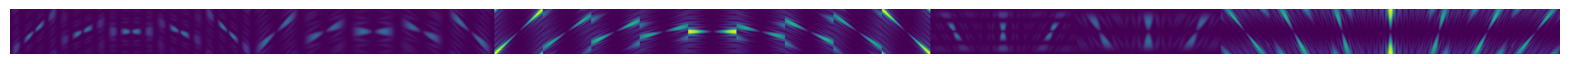

In [133]:
a = 0.3
f = cv.imread("data/interim/mito.tif", cv.IMREAD_GRAYSCALE)
f = cv.resize(cv.equalizeHist(f), (0,0), fx=a, fy=a)
f = cv.normalize(f, None, 0, 1, cv.NORM_MINMAX, cv.CV_32F)

scales =  3
dfilt = modulate2(dfilters("dmaxflat4", "d")[0], "c")
qmf = MakeONFilter('Haar')
swt_wavelet="haar"
h, w = f.shape[-2:]
pad_h = int(np.ceil(h/2**scales).item())*2**scales - h
pad_w = int(np.ceil(w/2**scales).item())*2**scales - w
f = np.pad(f, ((0,pad_h),(0,pad_w)), 'reflect')

shearletSystem = pyshearlab.SLgetShearletSystem2D(0, *f.shape[-2:], scales, full=0, directionalFilter=dfilt, quadratureMirrorFilter=qmf)

fig, ax = plt.subplots(figsize=(20,3))
ax.imshow(np.concat(np.permute_dims(np.abs(shearletSystem["shearlets"][:,:,:-1]),(2,0,1)),1))
ax.set_axis_off()

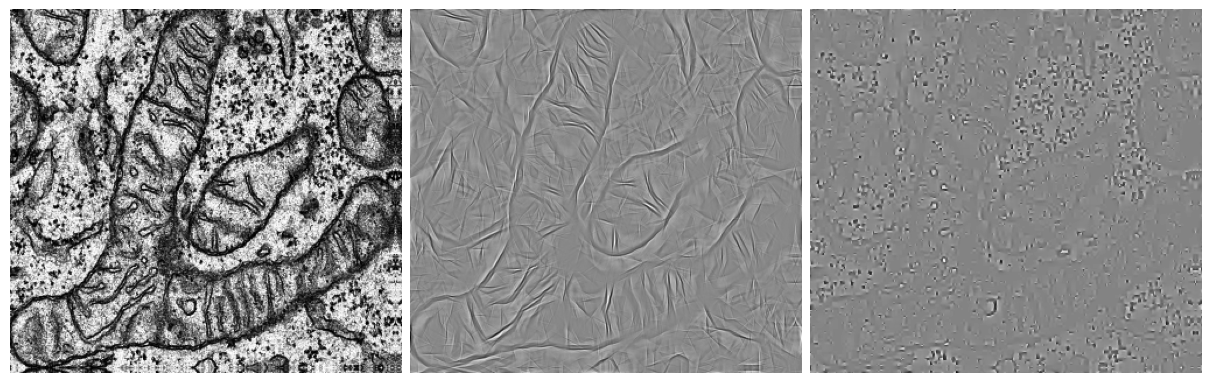

In [ ]:
f0, f1 = MCA(f, 10, shearletSystem, swt_wavelet)
#_,f0 = cv.threshold(cv.bitwise_not(cv.normalize(f0,None,0,255,cv.NORM_MINMAX,cv.CV_8U)), 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

fig, ax = plt.subplots(1,3, figsize=(12,6), layout="constrained")
for a,img in zip(ax,(f,f0,f1)):
    a.imshow(img, cmap='gray')
    a.set_axis_off()